# Abstractive Text Summarization


In [ ]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [ ]:
!pip install -q contractions==0.0.48

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.9 MB/s eta 0:00:00


In [ ]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


## 🪂 Getting the data

In [ ]:
import csv

with open("news_summary_more.csv", "r") as f:
    reader = csv.reader(f)
    data = list(reader)

# df = pd.DataFrame(data)
# df2 = pd.DataFrame(data2)
df1 = pd.DataFrame(data[1:], columns=data[0])


In [ ]:
with open("news_summary.csv", "r", encoding="latin-1") as f:
    reader = csv.reader(f)
    data = list(reader)
df2 = pd.DataFrame(data[1:], columns=data[0])


In [ ]:
df1.sample(5)

,headlines,text
47260,Waiting to hear from God about 2020 presidenti...,Amid speculations that she would contest the 2...
6991,"I was vocal, paid the price by having unfulfil...","Gautam Gambhir, who recently announced his ret..."
36568,Online campaign urges users to boycott Faceboo...,An online campaign called Faceblock is urging ...
8351,Sena assured support for Maratha quota Bill: M...,Maharashtra Revenue Minister Chandrakant Patil...
34397,Prez approves seizure of fugitive economic off...,President Ram Nath Kovind on Sunday promulgate...


In [ ]:
df2.sample(5)

,author,date,headlines,read_more,text,ctext
4137,Dishant Sharma,"22 Mar 2017,Wednesday",Pakistan cricket going through tough times: Pa...,http://indiatoday.intoday.in/story/pakistan-cr...,Pakistan cricket team's new ODI and T20I capta...,Pakistan's new ODI and T20 captain Sarfaraz Ah...
3756,Dishant Sharma,"18 Apr 2017,Tuesday",Australia's pace attack could decide Ashes ser...,http://indiatoday.intoday.in/story/brett-lee-a...,Former Australian pacer Brett Lee has said tha...,"Australia's pace attack, emboldened by the ret..."
1804,Aarushi Maheshwari,"31 Dec 2016,Saturday",Woman makes man give to charity for calling he...,http://indiatoday.intoday.in/story/kerala-woma...,Kerala-based Sreelakshmi Satheesh has said she...,"""When can I meet you? What is your ""rate""? ""Wi..."
4420,Chhavi Tyagi,"01 Mar 2017,Wednesday",Telangana CM gifts bungalows worth ?1 crore to...,http://indiatoday.intoday.in/story/telangana-g...,Telangana Chief Minister K Chandrashekar Rao h...,After Telangana Chief Minister K Chandrashekha...
2909,Rini Sinha,"22 Jun 2017,Thursday",Pak Twitter user trolled for sharing pic capti...,http://indiatoday.intoday.in/story/pakistani-m...,A Pakistani Twitter user was trolled after twe...,A Pakistani fellow stepped into the lion's den...


In [ ]:
df2_columns = df2.columns.tolist()
df2_columns.remove('headlines')
df2_columns.remove('text')
df2.drop(df2_columns, axis='columns', inplace=True)

df = pd.concat([df1, df2], axis='rows')
del df1, df2
# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102915


,headlines,text
79383,Kung Fu master uses his penis to tow bus,A video from China shows a Kung Fu master usin...
13309,Over 500 extremists attend neo-Nazi rally in B...,More than 500 right-wing extremists gathered o...
16418,Umesh's house robbed on day he's made RBI assi...,Indian pacer Umesh Yadav's Nagpur residence wa...
80358,We're far from being partners: Russia on ties ...,"Russia and Japan are still ""far from being par..."
9715,Bollywood director arrested for GST fraud of ...,"Vijay Gutte, director of Anupam Kher's 'The Ac..."


The `headlines` column will be treated as `summary` for the text.

## Data preparation

In [ ]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)
    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expanded_contraction:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [ ]:
# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)

df.sample(5)

,headlines,text
98666,facebook rolls out tools to block unwanted fri...,facebook has rolled out new tools which will a...
60598,400 prisoners escape libyan jail amid clashes,around 400 prisoners have escaped from a facil...
59932,journo who exposed malta's graft in panama pap...,maltese journalist caruana galizia who exposed...
73922,punjab congress mentions castes in list of spo...,the congress' punjab unit has released a list ...
81175,uk unveils new banknote featuring novelist jan...,the bank of england on tuesday unveiled a new ...


In [ ]:
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)

Streaming output truncated to the last 5000 lines.
augh
augu
janu
mar 
nove
mart
mark
augu
mark
mary
nova
octo
mark
jant
decl
decl
mars
mart
marc
nove
augh
mar 
mark
mark
augh
augh
augh
deca
june
june
mar 
augh
mar,
mar 
mar 
deci
deci
deco
marg
mark
deci
apri
apri
decl
decl
janu
jan 
dece
decl
mark
octo
decl
octo
octo
octo
mark
augh
augh
octo
juni
octo
octo
janu
mart
mara
sept
mara
augu
mart
juna
marr
marr
decl
june
mark
nova
deci
mar 
june
july
july
apri
octo
jana
deca
janu
deci
maro
augh
mar 
marr
febr
mari
augu
decl
augu
marr
mar 
mar 
mark
mark
mar,
mar 
mar 
mar,
mary
july
marc
marc
marc
decl
apri
apri
augh
sepa
nove
nove
june
mari
marr
janu
octo
octo
marg
octo
nove
augu
dece
mark
juni
mari
marr
marr
decl
octo
augu
sept
decl
octo
octo
deci
deci
june
sept
mar 
mark
marg
marr
marc
nove
juna
juna
augh
augh
mart
sepa
mart
mark
marc
febr
mart
mart
mart
marc
mart
augh
mar 
marc
marc
augu
mari
deci
deci
marr
augu
marc
deci
mari
sept
decl
decl
mark
deci
june
janu
octo
augh
mari
augh
augh

,headlines,text
28204,why was indias capital shifted from calcutta t...,delhi was officially announced as the capital ...
22076,man utd become first club to win 600 prthemier...,manchester united have become the first club t...
77572,"â¹22,800 device to mop and clean floors made",south korea-based robot cleaner manufacturer e...
28933,"cyber crooks target govts bhim app, steal ?45 ...",ups special task force has arrested two people...
21097,man fined â¹17 lakh for flying on balloon chair,a man who strapped helium balloons to a chair ...


In [ ]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [ ]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [ ]:
!pip install nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# prompt: Apply lemmetization on data

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(lemmatized_words)

df.headlines = df.headlines.apply(lemmatize_text)
df.text = df.text.apply(lemmatize_text)
df.sample(5)


,headlines,text
94067,delhi airport to get 1k immigration officer to...,"delhi igi airport will deploy 1,000 officer at..."
51283,we will send an indian to space by 2022: pm mo...,addressing the nation on the 72nd independence...
22570,sidhu and i are not at loggerheads: amarinder ...,punjab cm captain amarinder singh on sunday sa...
89187,how camera caught australian player ball-tampe...,ex-south african pacer and commentator fanie d...
83651,apple iphone x explodes after update in the u,a user in the united state ha claimed that his...


In [ ]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [ ]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
print(f'Dataset size: {len(df)}')
df.sample(5)

In [ ]:
# saving the cleaned data
df.to_csv('cleaned_data.csv')

In [ ]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

In [ ]:
plot_wordcloud(' '.join(df.headlines.values.tolist()), wc_blue_color_func)

In [ ]:
plot_wordcloud(' '.join(df.text.values.tolist()), wc_blue_color_func)

Using a `start` and `end` tokens in `headlines(summary)` to let the learning algorithm know from where the headlines start's and end's.

In [ ]:
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')

In [ ]:
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

In [ ]:
df.sample(5)

Finding what should be the `maximum length` of text and headlines that will be feed or accepted by the learning algorithm.

In [ ]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 60])
plt.show()

In [ ]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 26))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 100))

In [ ]:
max_text_len = 50
max_summary_len = 20

In [ ]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

In [ ]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [ ]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

**Tokenizing text

In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

In [ ]:
# else use this
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [ ]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

#Tokenizing headlines(Summary)

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

In [ ]:
# else use this
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [ ]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

In [ ]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

#Modelling

In [ ]:
latent_dim = 324
embedding_dim = 300
num_epochs = 30

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-11-10 18:10:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-10 18:10:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-10 18:10:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = 'glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

In [ ]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

**Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.

In [ ]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    # with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [ ]:
# prompt: add the attention mechanism

def build_seq2seq_model_with_attention(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # =====================
    # 🔥 Encoder
    # =====================
    encoder_input = Input(shape=(max_text_len,))

    # encoder embedding layer
    encoder_embedding = Embedding(
        x_vocab_size,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
        trainable=False
    )(encoder_input)

    # encoder lstm 1
    encoder_lstm1 = LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

    # encoder lstm 2
    encoder_lstm2 = LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

    # =====================
    # 🌈 Decoder
    # =====================

    decoder_input = Input(shape=(None,))

    # decoder embedding layer
    decoder_embedding_layer = Embedding(
        y_vocab_size,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
        trainable=True
    )
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # Attention Layer
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
    decoder_outputs, *decoder_final_states = decoder_lstm(decoder_embedding, initial_state=encoder_final_states)

    # Luong's attention mechanism
    attention = tf.keras.layers.Attention()
    context_vector = attention([decoder_outputs, encoder_output])

    # Concatenate attention output and decoder output
    decoder_concat_input = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, context_vector])

    # Dense layer for output
    decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_concat_input)

    # =====================
    # ⚡️ Model
    # =====================
    model = Model([encoder_input, decoder_input], decoder_outputs)

    model.summary()

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return {
        'model': model,
        'inputs': {
            'encoder': encoder_input,
            'decoder': decoder_input
        },
        'outputs': {
            'encoder': encoder_output,
            'decoder': decoder_outputs
        },
        'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
        },
        'layers': {
            'decoder': {
                'embedding': decoder_embedding_layer,
                'last_decoder_lstm': decoder_lstm,
                'dense': decoder_dense
            }
        }
    }

# ... (rest of your code, including training and inference) ...

# model_data = build_seq2seq_model_with_attention(
#     embedding_dim, latent_dim, max_text_len,
#     x_vocab_size, y_vocab_size,
#     x_embedding_matrix, y_embedding_matrix
# )
# model = model_data['model']


In [ ]:
# # prompt: generate inference for the attention

# def seq2seq_inference(input_sequence, model_data):
#     # Encode the input sequence
#     encoder_model = Model(inputs=model_data['inputs']['encoder'], outputs=model_data['outputs']['encoder'] + model_data['states']['encoder'])
#     encoder_out, *encoder_states = encoder_model.predict(input_sequence)

#     # Initialize the decoder input with the start token
#     target_seq = np.zeros((1, 1))
#     target_seq[0, 0] = y_tokenizer.word_index[start_token]

#     # Initialize the decoded sentence
#     decoded_sentence = ''

#     # Decode the output sequence
#     while True:
#         decoder_outputs, h, c = model_data['layers']['decoder']['last_decoder_lstm'](model_data['layers']['decoder']['embedding'](target_seq), initial_state=encoder_states)
#         attention = tf.keras.layers.Attention()
#         context_vector = attention([decoder_outputs, encoder_out])

#         decoder_concat_input = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, context_vector])
#         decoder_outputs = model_data['layers']['decoder']['dense'](decoder_concat_input)

#         # Sample the next word
#         sampled_word_index = np.argmax(decoder_outputs[0, -1, :])
#         sampled_word = None
#         for word, index in y_tokenizer.word_index.items():
#             if sampled_word_index == index:
#                 sampled_word = word
#                 break

#         # Append the sampled word to the decoded sentence
#         if sampled_word != end_token:
#             decoded_sentence += ' ' + sampled_word
#         else:
#             break

#         # Update the target sequence
#         target_seq = np.zeros((1, 1))
#         target_seq[0, 0] = sampled_word_index

#         # Update states
#         encoder_states = [h, c]

#     return decoded_sentence

# # Example usage (assuming you have a trained model and model_data)
# # input_sequence = x_val_padded[0].reshape(1, max_text_len)
# # decoded_summary = seq2seq_inference(input_sequence, model_data)
# # print(decoded_summary)

**Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.

In [ ]:
def build_seq2seq_model_with_bidirectional_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    # with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.2,
                name='decoder_lstm_1'
            ),
            name='decoder_bidirectional_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_bi_lstm(
            decoder_embedding, initial_state=encoder_final_states
            # decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_bi_lstm,
                    'dense': decoder_dense
                }
            }
        }

**Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

In [ ]:
def build_hybrid_seq2seq_model(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    # with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.2,
            name='decoder_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [ ]:
# seq2seq = build_seq2seq_model_with_just_lstm(
#     embedding_dim, latent_dim, max_text_len,
#     x_vocab_size, y_vocab_size,
#     x_embedding_matrix, y_embedding_matrix
# )

If you want to change `model` then just change the `function name` above.

In [ ]:

seq2seq = build_seq2seq_model_with_bidirectional_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)


In [ ]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [ ]:
model.layers[-2].input

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

Use a `tuple` instead of `list` in `validation_parameter` in `model.fit()`, to know the reason reading this [post](https://stackoverflow.com/questions/61586981/valueerror-layer-sequential-20-expects-1-inputs-but-it-received-2-input-tensor).

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 384s 511ms/step - accuracy: 0.5933 - loss: 3.7575 - val_accuracy: 0.6393 - val_loss: 3.1336 - learning_rate: 0.0010
Epoch 2/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 371s 506ms/step - accuracy: 0.6326 - loss: 3.1595 - val_accuracy: 0.6434 - val_loss: 2.9241 - learning_rate: 0.0010
Epoch 3/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 381s 505ms/step - accuracy: 0.6378 - loss: 2.9597 - val_accuracy: 0.6490 - val_loss: 2.7584 - learning_rate: 0.0010
Epoch 4/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 383s 507ms/step - accuracy: 0.6431 - loss: 2.8051 - val_accuracy: 0.6541 - val_loss: 2.6448 - learning_rate: 0.0010
Epoch 5/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 388s 515ms/step - accuracy: 0.6471 - loss: 2.6996 - val_accuracy: 0.6582 - val_loss: 2.5571 - learning_rate: 0.0010
Epoch 6/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 375s 505ms/step - accuracy: 0.6516 - loss: 2.6023 - val_accuracy: 0.6630 - val_loss: 2.4803 - learning_rate: 0.0010
Epoch 7/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 390s 517ms/step - accura

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # prompt: save the model in google drive



# # ... (your existing code) ...

# # Save the model to Google Drive
# model_path = '/content/drive/MyDrive/model_save/my_seq2seq_model.h5'  # Choose your desired path
# model.save(model_path)

# print(f"Model saved to: {model_path}")

In [ ]:
# pickle.dump(history,open('history2.pkl','wb'))

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

**Plotting model's performance**

In [ ]:
# Provide accuracy for the trained model

# history = pickle.load(open('/content/drive/MyDrive/proj2_model/history2.pkl','rb'))
acc = history.history['accuracy'][-1]
print(f'accuracy: {acc * 100:.2f}%')


accuracy: 70.99%


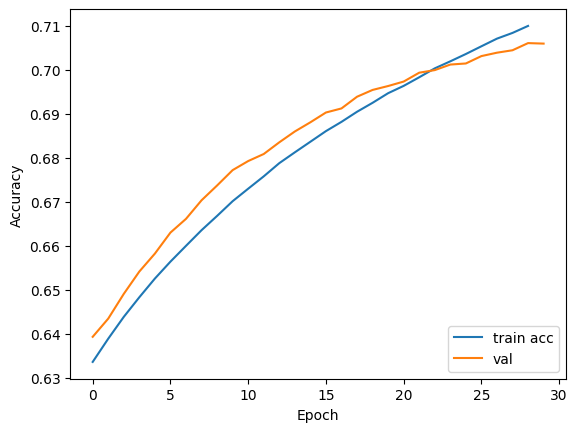

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

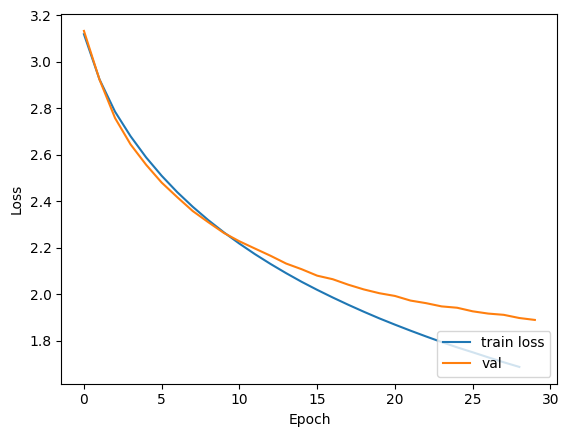

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

#Inference

In [ ]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
def build_seq2seq_model_with_attention_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # Attention layer
    attention = tf.keras.layers.Attention()
    context_vector = attention([decoder_output, decoder_hidden_state_input])

    # Concatenate attention output and decoder LSTM output
    decoder_concat_input = tf.keras.layers.Concatenate(axis=-1)([decoder_output, context_vector])


    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_concat_input)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
def build_seq2seq_model_with_bidirectional_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
def build_hybrid_seq2seq_model_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        #decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
encoder_model, decoder_model = build_seq2seq_model_with_attention_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 300)             │      29,654,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ [(None, 50, 324), (None,    │         810,000 │
│                                      │ 324), (None, 324)]          │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ [(None, 50, 324), (None,    │         841,104 │
│                                      │ 324), (None, 324)]          │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,305,504 (119.42 MB)

 Trainable params: 1,651,104 (6.30 MB)

 Non-trainable params: 29,654,400 (113.12 MB)

In [ ]:
decoder_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 300)      │     10,637,700 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 324)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 324)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, None, 324),    │        810,000 │ embedding_1[1][0],     │
│                           │ (None, 324), (None,    │                │ input_layer_2[0][0],   │
│                           │ 324)]                  │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 50, 324)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, None, 324)      │              0 │ lstm_2[1][0],          │
│                           │                        │                │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, None, 648)      │              0 │ lstm_2[1][0],          │
│ (Concatenate)             │                        │                │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 35459)    │     23,012,891 │ concatenate_1[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,460,591 (131.46 MB)

 Trainable params: 34,460,591 (131.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
decoder_model.layers[-3].input

[<KerasTensor shape=(None, None, 324), dtype=float32, sparse=False, name=keras_tensor_20>,
 <KerasTensor shape=(None, 50, 324), dtype=float32, sparse=None, name=keras_tensor_18>]

Converting from `sequence to text` for model `with just LSTM's` and for model `with Bidirectional LSTM's`.

In [ ]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def decode_sequence_seq2seq_model_with_bidirectional_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [ ]:
def decode_sequence_hybrid_seq2seq_model(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values[:2]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [ ]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [ ]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [ ]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])

print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


For predicting `unseen` data pass `decode_sequence` function for which you want to decode.

In [ ]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

In [ ]:
history

#Predictions

In [ ]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  talking upcoming india tour australia spin legend shane warne said first rthemthember india come australia test match favourites india smell blood fear australia added think australia batting disarraythey need something pretty quickly warne said 
Original summary:  start india smell blood fear australia warne india tour end 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted summary:   start india first daynight blood test australia end

# 2 News:  mumbai attack mastermind jamaatuddawah jud chief hafiz saeed saturday announced plan contest pakistan general election next year pakistani medium reported saeed designated global terrorist intend

In [ ]:
# prompt: evaluation using bert score

!pip install bert_score

from bert_score import score

def evaluate_bert_score(references, candidates):
  """
  Calculates BERT score for a list of reference and candidate summaries.

  Args:
    references: A list of reference summaries (strings).
    candidates: A list of candidate summaries (strings).

  Returns:
    A tuple containing the precision, recall, and F1 scores.
  """
  P, R, F1 = score(candidates, references, lang="en", verbose=True)
  return P.mean().item(), R.mean().item(), F1.mean().item()

# Example usage:
references = []
candidates = []

for i in range(0, 15):
    original_summary = seq2summary(y_train_padded[i])
    predicted_summary = decode_sequence_seq2seq_model_with_just_lstm(
        x_train_padded[i].reshape(1, max_text_len), encoder_model, decoder_model
    )
    references.append(original_summary)
    candidates.append(predicted_summary)

precision, recall, f1 = evaluate_bert_score(references, candidates)

print(f"BERT Score Precision: {precision:.4f}")
print(f"BERT Score Recall: {recall:.4f}")
print(f"BERT Score F1: {f1:.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.6 MB/s eta 0:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.79 seconds, 8.40 sentences/sec
BERT Score Precision: 0.8952
BERT Score Recall: 0.8851
BERT Score F1: 0.8900


In [ ]:
# prompt: Compute Rouge Score of the model

!pip install rouge
from rouge import Rouge

rouge = Rouge()
model_predictions = []
target_summaries = []

for i in range(0, 50):
    pred = decode_sequence_seq2seq_model_with_just_lstm(
        x_train_padded[i].reshape(1, max_text_len), encoder_model, decoder_model
    )
    model_predictions.append(pred)
    target_summaries.append(seq2summary(y_train_padded[i]))

scores = rouge.get_scores(model_predictions, target_summaries)

print("Rouge-1 F1 Score:", scores[0]["rouge-1"]["f"])
print("Rouge-2 F1 Score:", scores[0]["rouge-2"]["f"])
print("Rouge-L F1 Score:", scores[0]["rouge-l"]["f"])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [ ]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", seq2summary(y_val_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  responding report dream sequence padmavati alauddin khilji film padmavati sanjay leela bhansali said interaction whatsoever character portrayed deepika padukone ranveer singh padmavati ha made lot responsibility hard work added bhansali said kept honour rajput intact 
Original summary:  start interaction padmavati khilji film bhansali end 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted summary:   start padmavati character ranveer padmavati row end

# 2 News:  actor saif ali khan asked koffee karan would ask daughter sara ali khan boyfriend answered political views drugs karan suggested ask man ha money saif jokingly rthemarked got cash take later show sara said want date kart

## 🎁 Saving the model

In [ ]:
# HDF5 format
model.save('model.h5')
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

In [ ]:
# prompt: import the saved model

from tensorflow.keras.models import load_model
model = load_model('model.h5')


## 🏌️‍♂️ Running all the 3 different models

After understanding how all the pieces work, running all the `3 models` to understand how it `performs` and its `results`.

**Here there 3 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**Inference methods for the 3 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`
- `build_hybrid_seq2seq_model_inference`

**Decoding sequence for the 3 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`
- `decode_sequence_build_hybrid_seq2seq_model`


In [ ]:
models_info = {
    'just_lstm': {
        'model': build_seq2seq_model_with_just_lstm,
        'inference': build_seq2seq_model_with_just_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_just_lstm
    },
    'bidirectional_lstm': {
        'model': build_seq2seq_model_with_bidirectional_lstm,
        'inference': build_seq2seq_model_with_bidirectional_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_bidirectional_lstm
    },
    'hybrid_model': {
        'model': build_hybrid_seq2seq_model,
        'inference': build_hybrid_seq2seq_model_inference,
        'decode_sequence': decode_sequence_hybrid_seq2seq_model
    }
}

**Model with just LSTMs**

In [ ]:
model_func = models_info['just_lstm']['model']
inference_func = models_info['just_lstm']['inference']
decode_sequence_func = models_info['just_lstm']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 100, 300)       │      8,517,600 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, 100, 240),     │        519,360 │ embedding_4[0][0]      │
│                           │ (None, 240), (None,    │                │                        │
│                           │ 240)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, None, 300)      │      3,460,800 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ [(None, 100, 240),     │        461,760 │ lstm_6[0][0]           │
│                           │ (None, 240), (None,    │                │                        │
│                           │ 240)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ [(None, None, 240),    │        519,360 │ embedding_5[0][0],     │
│                           │ (None, 240), (None,    │                │ lstm_7[0][1],          │
│                           │ 240)]                  │                │ lstm_7[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, None, 11536)    │      2,780,176 │ lstm_8[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,259,056 (62.02 MB)

 Trainable params: 7,741,456 (29.53 MB)

 Non-trainable params: 8,517,600 (32.49 MB)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 100, 300)       │      8,517,600 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, 100, 240),     │        519,360 │ embedding_4[0][0]      │
│                           │ (None, 240), (None,    │                │                        │
│                           │ 240)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, None, 300)      │      3,460,800 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ [(None, 100, 240),     │        461,760 │ lstm_6[0][0]           │
│                           │ (None, 240), (None,    │                │                        │
│                           │ 240)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ [(None, None, 240),    │        519,360 │ embedding_5[0][0],     │
│                           │ (None, 240), (None,    │                │ lstm_7[0][1],          │
│                           │ 240)]                  │                │ lstm_7[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, None, 11536)    │      2,780,176 │ lstm_8[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,259,056 (62.02 MB)

 Trainable params: 7,741,456 (29.53 MB)

 Non-trainable params: 8,517,600 (32.49 MB)

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 886ms/step - accuracy: 0.5610 - loss: 5.6458 - val_accuracy: 0.6808 - val_loss: 2.5313 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 463ms/step - accuracy: 0.6600 - loss: 2.7205 - val_accuracy: 0.7359 - val_loss: 2.2839 - learning_rate: 0.0010
Epoch 2: early stopping


In [ ]:
pickle.dump(history,open('history3.pkl','wb'))

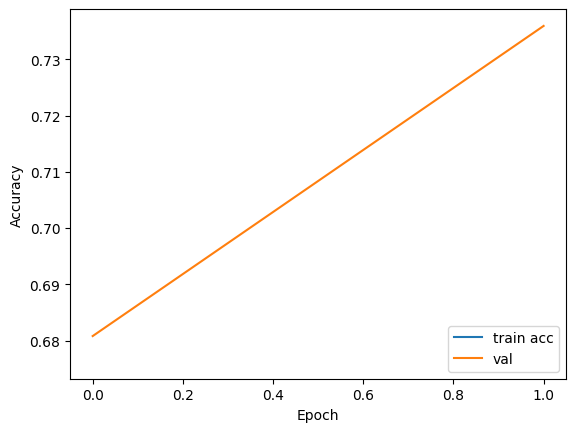

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

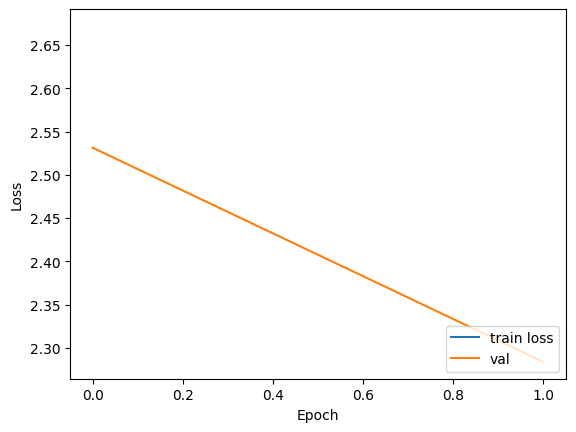

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 100, 300)            │       8,517,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ [(None, 100, 240), (None,   │         519,360 │
│                                      │ 240), (None, 240)]          │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ [(None, 100, 240), (None,   │         461,760 │
│                                      │ 240), (None, 240)]          │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,498,720 (36.23 MB)

 Trainable params: 981,120 (3.74 MB)

 Non-trainable params: 8,517,600 (32.49 MB)

In [ ]:
decoder_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, None, 300)      │      3,460,800 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 240)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 240)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ [(None, None, 240),    │        519,360 │ embedding_5[1][0],     │
│                           │ (None, 240), (None,    │                │ input_layer_9[0][0],   │
│                           │ 240)]                  │                │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 100, 240)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, None, 11536)    │      2,780,176 │ lstm_8[1][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,760,336 (25.79 MB)

 Trainable params: 6,760,336 (25.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  serbian tennis player novak djokovic went past former world number one pete sampras tally grand slam title winning seventh australian open title sunday seventh win djokovic extended record final australian open djokovic hold winning headtohead record rafael nadal roger federer 
Original summary:  start djokovic ha record australian open final end 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted summary:   start start end

# 2 News:  allahabad high court ha stayed uttar pradesh government order include subcastes scheduled caste category december government issued order naming subcastes earlier classified backward class category sc list recently hc directed state file reply petition challenging decision 
Original summary:  start allahabad hc stay inclusion subcastes sc category end 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━

**Model with Bidirectional LSTMs**

In [ ]:
model_func = models_info['bidirectional_lstm']['model']
inference_func = models_info['bidirectional_lstm']['inference']
decode_sequence_func = models_info['bidirectional_lstm']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 100, 300)       │     17,514,600 │ input_layer_16[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional_ls… │ [(None, 100, 648),     │      1,620,000 │ encoder_embedding[0][… │
│ (Bidirectional)           │ (None, 324), (None,    │                │                        │
│                           │ 324), (None, 324),     │                │                        │
│                           │ (None, 324)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_17            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional_ls… │ [(None, 100, 648),     │      2,522,016 │ encoder_bidirectional… │
│ (Bidirectional)           │ (None, 324), (None,    │                │                        │
│                           │ 324), (None, 324),     │                │                        │
│                           │ (None, 324)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 300)      │      6,764,400 │ input_layer_17[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional_ls… │ [(None, 100, 648),     │      2,522,016 │ encoder_bidirectional… │
│ (Bidirectional)           │ (None, 324), (None,    │                │                        │
│                           │ 324), (None, 324),     │                │                        │
│                           │ (None, 324)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_bidirectional_ls… │ [(None, None, 648),    │      1,620,000 │ decoder_embedding[0][… │
│ (Bidirectional)           │ (None, 324), (None,    │                │ encoder_bidirectional… │
│                           │ 324), (None, 324),     │                │ encoder_bidirectional… │
│                           │ (None, 324)]           │                │ encoder_bidirectional… │
│                           │                        │                │ encoder_bidirectional… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, None, 22548)    │     14,633,652 │ decoder_bidirectional… │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 47,196,684 (180.04 MB)

 Trainable params: 22,917,684 (87.42 MB)

 Non-trainable params: 24,279,000 (92.62 MB)

Model: "seq2seq_model_with_bidirectional_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 100, 300)       │     17,514,600 │ input_layer_16[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional_ls… │ [(None, 100, 648),     │      1,620,000 │ encoder_embedding[0][… │
│ (Bidirectional)           │ (None, 324), (None,    │                │                        │
│                           │ 324), (None, 324),     │                │                        │
│                           │ (None, 324)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_17            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional_ls… │ [(None, 100, 648),     │      2,522,016 │ encoder_bidirectional… │
│ (Bidirectional)           │ (None, 324), (None,    │                │                        │
│                           │ 324), (None, 324),     │                │                        │
│                           │ (None, 324)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 300)      │      6,764,400 │ input_layer_17[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional_ls… │ [(None, 100, 648),     │      2,522,016 │ encoder_bidirectional… │
│ (Bidirectional)           │ (None, 324), (None,    │                │                        │
│                           │ 324), (None, 324),     │                │                        │
│                           │ (None, 324)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_bidirectional_ls… │ [(None, None, 648),    │      1,620,000 │ decoder_embedding[0][… │
│ (Bidirectional)           │ (None, 324), (None,    │                │ encoder_bidirectional… │
│                           │ 324), (None, 324),     │                │ encoder_bidirectional… │
│                           │ (None, 324)]           │                │ encoder_bidirectional… │
│                           │                        │                │ encoder_bidirectional… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, None, 22548)    │     14,633,652 │ decoder_bidirectional… │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 47,196,684 (180.04 MB)

 Trainable params: 22,917,684 (87.42 MB)

 Non-trainable params: 24,279,000 (92.62 MB)

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.6399 - loss: 3.6073 - val_accuracy: 0.7241 - val_loss: 2.3448 - learning_rate: 0.0010
Epoch 2/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.7136 - loss: 2.4385 - val_accuracy: 0.7311 - val_loss: 2.2119 - learning_rate: 0.0010
Epoch 2: early stopping


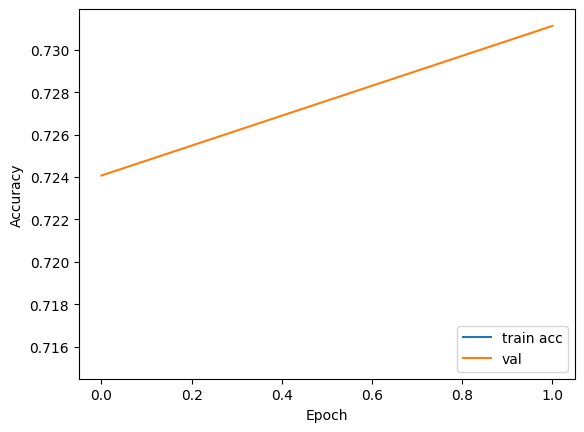

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

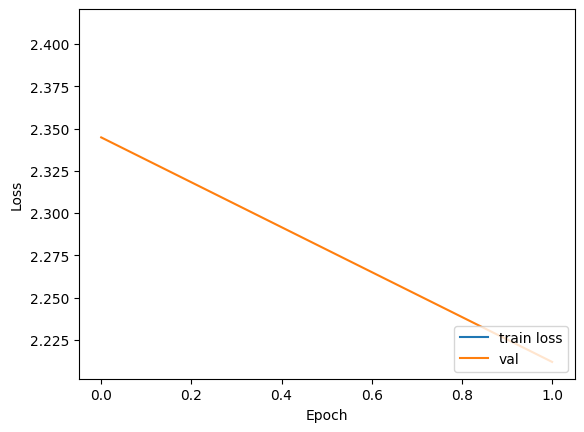

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_embedding (Embedding)        │ (None, 100, 300)            │      17,514,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bidirectional_lstm_1         │ [(None, 100, 648), (None,   │       1,620,000 │
│ (Bidirectional)                      │ 324), (None, 324), (None,   │                 │
│                                      │ 324), (None, 324)]          │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bidirectional_lstm_2         │ [(None, 100, 648), (None,   │       2,522,016 │
│ (Bidirectional)                      │ 324), (None, 324), (None,   │                 │
│                                      │ 324), (None, 324)]          │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bidirectional_lstm_3         │ [(None, 100, 648), (None,   │       2,522,016 │
│ (Bidirectional)                      │ 324), (None, 324), (None,   │                 │
│                                      │ 324), (None, 324)]          │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,178,632 (92.23 MB)

 Trainable params: 6,664,032 (25.42 MB)

 Non-trainable params: 17,514,600 (66.81 MB)

In [ ]:
decoder_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 300)      │      6,764,400 │ input_layer_17[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_18            │ (None, 324)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_19            │ (None, 324)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_20            │ (None, 324)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_21            │ (None, 324)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_bidirectional_ls… │ [(None, None, 648),    │      1,620,000 │ decoder_embedding[1][… │
│ (Bidirectional)           │ (None, 324), (None,    │                │ input_layer_18[0][0],  │
│                           │ 324), (None, 324),     │                │ input_layer_19[0][0],  │
│                           │ (None, 324)]           │                │ input_layer_20[0][0],  │
│                           │                        │                │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_22            │ (None, 100, 648)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, None, 22548)    │     14,633,652 │ decoder_bidirectional… │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,018,052 (87.81 MB)

 Trainable params: 16,253,652 (62.00 MB)

 Non-trainable params: 6,764,400 (25.80 MB)

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  european space agency astronaut current resident alexander gerst ha discovered old nasa floppy disk space station found locker spacestation probably ha opened gerst tweeted one floppy labeled containing norton utility window nasa symbol labels 
Original summary:  start astronaut find old nasa floppy disk space station end 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━

In [ ]:
# prompt: evaluation using bert score

!pip install bert_score

from bert_score import score

def evaluate_bert_score(references, candidates):
  """
  Calculates BERT score for a list of reference and candidate summaries.

  Args:
    references: A list of reference summaries (strings).
    candidates: A list of candidate summaries (strings).

  Returns:
    A tuple containing the precision, recall, and F1 scores.
  """
  P, R, F1 = score(candidates, references, lang="en", verbose=True)
  return P.mean().item(), R.mean().item(), F1.mean().item()

# Example usage:
references = []
candidates = []

for i in range(0, 15):
    original_summary = seq2summary(y_train_padded[i])
    predicted_summary = decode_sequence_func(
        x_train_padded[i].reshape(1, max_text_len), encoder_model, decoder_model
    )
    references.append(original_summary)
    candidates.append(predicted_summary)

precision, recall, f1 = evaluate_bert_score(references, candidates)

print(f"BERT Score Precision: {precision:.4f}")
print(f"BERT Score Recall: {recall:.4f}")
print(f"BERT Score F1: {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.46 seconds, 32.45 sentences/sec
BERT Score Precision: 0.7424
BERT Score Recall: 0.8127
BERT Score F1: 0.7757


In [ ]:
# prompt: Compute Rouge Score of the model

!pip install rouge
from rouge import Rouge

rouge = Rouge()
model_predictions = []
target_summaries = []

for i in range(0, 50):
    pred = decode_sequence_func(
        x_train_padded[i].reshape(1, max_text_len), encoder_model, decoder_model
    )
    model_predictions.append(pred)
    target_summaries.append(seq2summary(y_train_padded[i]))

scores = rouge.get_scores(model_predictions, target_summaries)

print("Rouge-1 F1 Score:", scores[0]["rouge-1"]["f"])
print("Rouge-2 F1 Score:", scores[0]["rouge-2"]["f"])
print("Rouge-L F1 Score:", scores[0]["rouge-l"]["f"])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

In [ ]:
model_func = models_info['hybrid_model']['model']
inference_func = models_info['hybrid_model']['inference']
decode_sequence_func = models_info['hybrid_model']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 100, 300)       │     17,514,600 │ input_layer_23[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional_ls… │ [(None, 100, 648),     │      1,620,000 │ encoder_embedding[0][… │
│ (Bidirectional)           │ (None, 324), (None,    │                │                        │
│                           │ 324), (None, 324),     │                │                        │
│                           │ (None, 324)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_24            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional_ls… │ [(None, 100, 648),     │      2,522,016 │ encoder_bidirectional… │
│ (Bidirectional)           │ (None, 324), (None,    │                │                        │
│                           │ 324), (None, 324),     │                │                        │
│                           │ (None, 324)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 300)      │      6,764,400 │ input_layer_24[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional_ls… │ [(None, 100, 648),     │      2,522,016 │ encoder_bidirectional… │
│ (Bidirectional)           │ (None, 324), (None,    │                │                        │
│                           │ 324), (None, 324),     │                │                        │
│                           │ (None, 324)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm_1 (LSTM)     │ [(None, None, 324),    │        810,000 │ decoder_embedding[0][… │
│                           │ (None, 324), (None,    │                │ encoder_bidirectional… │
│                           │ 324)]                  │                │ encoder_bidirectional… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, None, 22548)    │      7,328,100 │ decoder_lstm_1[0][0]   │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 39,081,132 (149.08 MB)

 Trainable params: 14,802,132 (56.47 MB)

 Non-trainable params: 24,279,000 (92.62 MB)

Model: "seq2seq_model_with_bidirectional_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 100, 300)       │     17,514,600 │ input_layer_23[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional_ls… │ [(None, 100, 648),     │      1,620,000 │ encoder_embedding[0][… │
│ (Bidirectional)           │ (None, 324), (None,    │                │                        │
│                           │ 324), (None, 324),     │                │                        │
│                           │ (None, 324)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_24            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional_ls… │ [(None, 100, 648),     │      2,522,016 │ encoder_bidirectional… │
│ (Bidirectional)           │ (None, 324), (None,    │                │                        │
│                           │ 324), (None, 324),     │                │                        │
│                           │ (None, 324)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 300)      │      6,764,400 │ input_layer_24[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirectional_ls… │ [(None, 100, 648),     │      2,522,016 │ encoder_bidirectional… │
│ (Bidirectional)           │ (None, 324), (None,    │                │                        │
│                           │ 324), (None, 324),     │                │                        │
│                           │ (None, 324)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm_1 (LSTM)     │ [(None, None, 324),    │        810,000 │ decoder_embedding[0][… │
│                           │ (None, 324), (None,    │                │ encoder_bidirectional… │
│                           │ 324)]                  │                │ encoder_bidirectional… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, None, 22548)    │      7,328,100 │ decoder_lstm_1[0][0]   │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 39,081,132 (149.08 MB)

 Trainable params: 14,802,132 (56.47 MB)

 Non-trainable params: 24,279,000 (92.62 MB)

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


259/259 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.6316 - loss: 3.8725 - val_accuracy: 0.7228 - val_loss: 2.3893 - learning_rate: 0.0010
Epoch 2/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.7111 - loss: 2.5049 - val_accuracy: 0.7233 - val_loss: 2.3603 - learning_rate: 0.0010
Epoch 2: early stopping


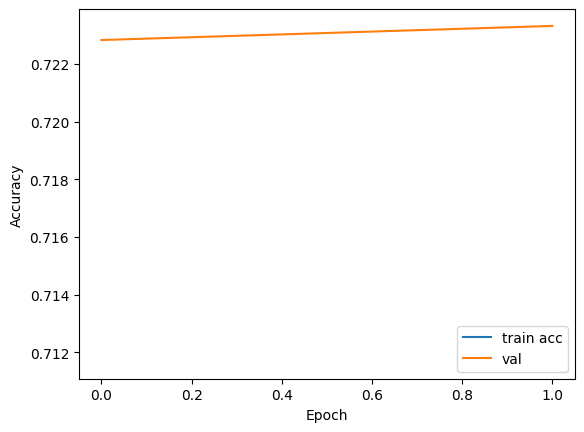

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

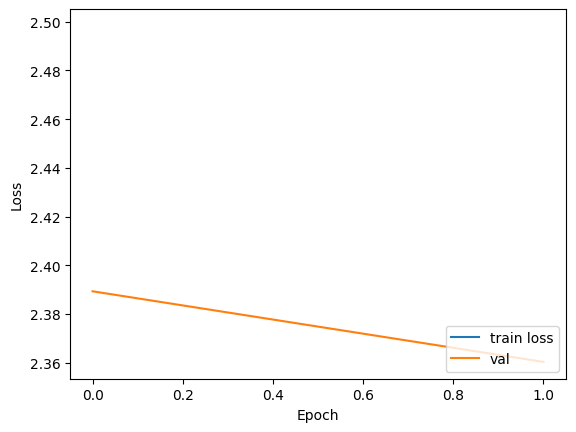

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_embedding (Embedding)        │ (None, 100, 300)            │      17,514,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bidirectional_lstm_1         │ [(None, 100, 648), (None,   │       1,620,000 │
│ (Bidirectional)                      │ 324), (None, 324), (None,   │                 │
│                                      │ 324), (None, 324)]          │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bidirectional_lstm_2         │ [(None, 100, 648), (None,   │       2,522,016 │
│ (Bidirectional)                      │ 324), (None, 324), (None,   │                 │
│                                      │ 324), (None, 324)]          │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bidirectional_lstm_3         │ [(None, 100, 648), (None,   │       2,522,016 │
│ (Bidirectional)                      │ 324), (None, 324), (None,   │                 │
│                                      │ 324), (None, 324)]          │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,178,632 (92.23 MB)

 Trainable params: 6,664,032 (25.42 MB)

 Non-trainable params: 17,514,600 (66.81 MB)

In [ ]:
decoder_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 300)      │      6,764,400 │ input_layer_24[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_25            │ (None, 324)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_26            │ (None, 324)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm_1 (LSTM)     │ [(None, None, 324),    │        810,000 │ decoder_embedding[1][… │
│                           │ (None, 324), (None,    │                │ input_layer_25[0][0],  │
│                           │ 324)]                  │                │ input_layer_26[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_27            │ (None, 100, 648)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, None, 22548)    │      7,328,100 │ decoder_lstm_1[1][0]   │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,902,500 (56.85 MB)

 Trainable params: 8,138,100 (31.04 MB)

 Non-trainable params: 6,764,400 (25.80 MB)

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  european space agency astronaut current resident alexander gerst ha discovered old nasa floppy disk space station found locker spacestation probably ha opened gerst tweeted one floppy labeled containing norton utility window nasa symbol labels 
Original summary:  start astronaut find old nasa floppy disk space station end 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━